In [1]:
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("GenericAppName") \
    .getOrCreate()

22/12/06 12:50:17 WARN Utils: Your hostname, hsMac.local resolves to a loopback address: 127.0.0.1; using 172.26.114.33 instead (on interface en0)
22/12/06 12:50:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/06 12:50:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [96]:
origin = pd.read_csv('new_data_merge.csv')
train = pd.read_csv('./roost/train.csv')
test = pd.read_csv('./roost/test.csv')
train.columns=['material_id','material','tc']
test.columns=['material_id','material','tc']
new_train = pd.merge(train['material'],origin,on=['material'],how='inner')
new_test = pd.merge(test['material'],origin,on=['material'],how='inner')

new_train.to_csv("./sparkml_data/3/train.csv",index=None)
new_test.to_csv("./sparkml_data/3/test.csv",index=None)


In [2]:
train = spark.read.csv('./sparkml_data/train.csv',header=True,inferSchema=True)
test = spark.read.csv('./sparkml_data/test.csv',header=True,inferSchema=True)

train.printSchema()


root
 |-- material: string (nullable = true)
 |-- number_of_elements: double (nullable = true)
 |-- mean_atomic_mass: double (nullable = true)
 |-- wtd_mean_atomic_mass: double (nullable = true)
 |-- gmean_atomic_mass: double (nullable = true)
 |-- wtd_gmean_atomic_mass: double (nullable = true)
 |-- entropy_atomic_mass: double (nullable = true)
 |-- wtd_entropy_atomic_mass: double (nullable = true)
 |-- range_atomic_mass: double (nullable = true)
 |-- wtd_range_atomic_mass: double (nullable = true)
 |-- std_atomic_mass: double (nullable = true)
 |-- wtd_std_atomic_mass: double (nullable = true)
 |-- mean_fie: double (nullable = true)
 |-- wtd_mean_fie: double (nullable = true)
 |-- gmean_fie: double (nullable = true)
 |-- wtd_gmean_fie: double (nullable = true)
 |-- entropy_fie: double (nullable = true)
 |-- wtd_entropy_fie: double (nullable = true)
 |-- range_fie: double (nullable = true)
 |-- wtd_range_fie: double (nullable = true)
 |-- std_fie: double (nullable = true)
 |-- wtd_std

In [3]:
continuous_cols = ['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass', 'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 
'entropy_atomic_mass', 'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass', 'std_atomic_mass', 'wtd_std_atomic_mass', 
'mean_fie', 'wtd_mean_fie', 'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'wtd_entropy_fie', 'range_fie', 'wtd_range_fie', 'std_fie', 
'wtd_std_fie', 'mean_atomic_radius', 'wtd_mean_atomic_radius', 'gmean_atomic_radius', 'wtd_gmean_atomic_radius', 'entropy_atomic_radius', 
'wtd_entropy_atomic_radius', 'range_atomic_radius', 'wtd_range_atomic_radius', 'std_atomic_radius', 'wtd_std_atomic_radius', 
'mean_Density', 'wtd_mean_Density', 'gmean_Density', 'wtd_gmean_Density', 'entropy_Density', 'wtd_entropy_Density', 'range_Density', 
'wtd_range_Density', 'std_Density', 'wtd_std_Density', 'mean_ElectronAffinity', 'wtd_mean_ElectronAffinity', 'gmean_ElectronAffinity', 
'wtd_gmean_ElectronAffinity', 'entropy_ElectronAffinity', 'wtd_entropy_ElectronAffinity', 'range_ElectronAffinity', 'wtd_range_ElectronAffinity', 
'std_ElectronAffinity', 'wtd_std_ElectronAffinity', 'mean_FusionHeat', 'wtd_mean_FusionHeat', 'gmean_FusionHeat', 'wtd_gmean_FusionHeat', 
'entropy_FusionHeat', 'wtd_entropy_FusionHeat', 'range_FusionHeat', 'wtd_range_FusionHeat', 'std_FusionHeat', 'wtd_std_FusionHeat', 
'mean_ThermalConductivity', 'wtd_mean_ThermalConductivity', 'gmean_ThermalConductivity', 'wtd_gmean_ThermalConductivity', 
'entropy_ThermalConductivity', 'wtd_entropy_ThermalConductivity', 'range_ThermalConductivity', 'wtd_range_ThermalConductivity',
 'std_ThermalConductivity', 'wtd_std_ThermalConductivity', 'mean_Valence', 'wtd_mean_Valence', 'gmean_Valence', 'wtd_gmean_Valence',
  'entropy_Valence', 'wtd_entropy_Valence', 'range_Valence', 'wtd_range_Valence', 'std_Valence', 'wtd_std_Valence', 'H', 'He', 'Li',
   'Be', 'B', 'C', 'N', 'O', 'F', 'Ne', 'Na', 'Mg', 'Al', 'Si', 'P', 'S', 'Cl', 'Ar', 'K', 'Ca', 'Sc', 'Ti', 'V', 'Cr', 'Mn', 'Fe',
    'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Ge', 'As', 'Se', 'Br', 'Kr', 'Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Ag', 'Cd', 
    'In', 'Sn', 'Sb', 'Te', 'I', 'Xe', 'Cs', 'Ba', 'La', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu',
     'Hf', 'Ta', 'W', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Hg', 'Tl', 'Pb', 'Bi', 'Po', 'At', 'Rn']
binary_cols = []
nominal_cols = []
class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset.withColumn('label', col('critical_temp').cast(DoubleType()))
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self):
        super().__init__()

    def _transform(self, dataset):
        output_df = dataset
        for col_name in binary_cols + continuous_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df
class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    stage_typecaster = FeatureTypeCaster()

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols = nominal_cols, outputCols = nominal_id_cols )

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = continuous_cols+binary_cols+nominal_onehot_cols
    # corelated_cols_to_remove = ["dst_host_serror_rate","srv_serror_rate","dst_host_srv_serror_rate",
    #                  "srv_rerror_rate","dst_host_rerror_rate","dst_host_srv_rerror_rate"]
    # for col_name in corelated_cols_to_remove:
    #     feature_cols.remove(col_name)
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')
    

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols+nominal_id_cols+
        nominal_onehot_cols+ binary_cols + continuous_cols + ['vectorized_features']+['critical_temp']+['material'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster,stage_nominal_indexer,stage_nominal_onehot_encoder,
        stage_vector_assembler,stage_scaler,stage_outcome,stage_column_dropper])
    return pipeline 

In [4]:
preprocess_pipeline = get_preprocess_pipeline()

pipline_model = preprocess_pipeline.fit(train)
train_df = pipline_model.transform(train)
test_df = pipline_model.transform(test)

train_df.show(5)

22/12/06 12:51:12 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
+--------------------+-----+
|            features|label|
+--------------------+-----+
|(167,[0,1,2,3,4,5...|  5.6|
|(167,[0,1,2,3,4,5...|16.95|
|(167,[0,1,2,3,4,5...| 85.5|
|(167,[0,1,2,3,4,5...| 33.0|
|(167,[0,1,2,3,4,5...| 77.0|
+--------------------+-----+
only showing top 5 rows



In [5]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import LinearRegression,GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator




lr = LinearRegression()
rf = RandomForestRegressor()
gbt = GBTRegressor()
lr_model = lr.fit(train_df)
rf_model = rf.fit(train_df)
gbt_model = gbt.fit(train_df)
lr_pred = lr_model.transform(test_df)
rf_pred = rf_model.transform(test_df)
gbt_pred = gbt_model.transform(test_df)

22/12/06 12:51:35 WARN Instrumentation: [09b66281] regParam is zero, which might cause numerical instability and overfitting.
22/12/06 12:51:35 WARN InstanceBuilder$JavaBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
22/12/06 12:51:35 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/12/06 12:51:35 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
22/12/06 12:51:35 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK
22/12/06 12:51:35 WARN Instrumentation: [09b66281] Cholesky solver failed due to singular covariance matrix. Retrying with Quasi-Newton solver.


In [6]:
lr_result = lr_pred.toPandas()
lr_result = lr_result.drop(columns=['features'])
rf_result = rf_pred.toPandas()
rf_result = rf_result.drop(columns=['features'])
gbt_result = gbt_pred.toPandas()
gbt_result = gbt_result.drop(columns=['features'])

In [7]:
lr_result.to_csv('./lr_result/lr_result_reduced',index=None)
rf_result.to_csv('./rf_result/rf_result_reduced',index=None)
gbt_result.to_csv('./gbt_result/gbt_result_reduced',index=None)

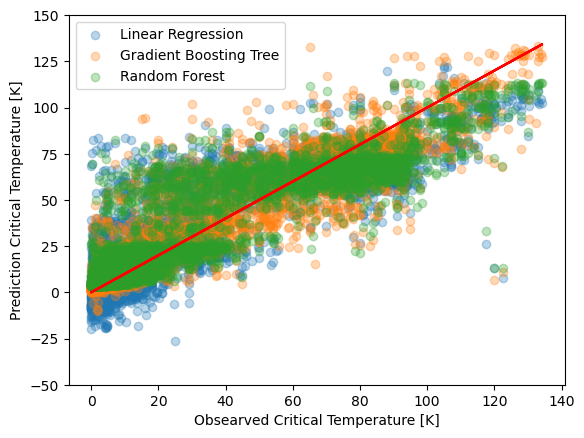

22/12/06 15:39:27 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 150684 ms exceeds timeout 120000 ms
22/12/06 15:39:27 WARN SparkContext: Killing executors is not supported by current scheduler.


In [14]:
import matplotlib.pyplot as plt
lr_result = lr_pred.toPandas()
lr_result = lr_result.drop(columns=['features'])
rf_result = rf_pred.toPandas()
rf_result = rf_result.drop(columns=['features'])
gbt_result = gbt_pred.toPandas()
gbt_result = gbt_result.drop(columns=['features'])
plt.scatter(lr_result.label,lr_result.prediction,alpha=0.3,label='Linear Regression')
plt.plot(lr_result.label,lr_result.label,c='r')
# plt.figure()
plt.scatter(gbt_result.label,gbt_result.prediction,alpha=0.3,label='Gradient Boosting Tree')
plt.plot(gbt_result.label,gbt_result.label,c='r')
# plt.figure()
plt.scatter(rf_result.label,rf_result.prediction,alpha=0.3,label='Random Forest')
plt.plot(rf_result.label,rf_result.label,c='r')

plt.ylim(-50,150)
plt.xlabel('Obsearved Critical Temperature [K]')

plt.ylabel('Prediction Critical Temperature [K]')
plt.legend()


In [10]:
from sklearn.metrics import r2_score


print(r2_score(rf_result.label,rf_result.prediction))
print(r2_score(lr_result.label,lr_result.prediction))
print(r2_score(gbt_result.label,gbt_result.prediction))


0.8111719594804763
-0.8138444879183635
0.8569835073242817


0.8890412979503874


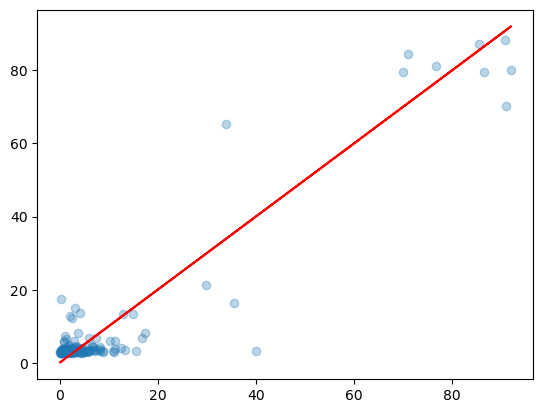

In [72]:
import matplotlib.pyplot as plt
rf_result = rf_pred.toPandas()
rf_result = rf_result.drop(columns=['features'])
# print(type(lr_pred))
# print(lr_result)
plt.scatter(rf_result.label,rf_result.prediction,alpha=0.3)
plt.plot(rf_result.label,rf_result.label,c='r')
print(r2_score(rf_result.label,rf_result.prediction))


In [62]:
lr_result.to_csv('./linear_regression/lr_result2',index=None)

In [63]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae


print(r2_score(lr_result.label,lr_result.prediction))

-3.119444953009463
